### Extract outcome variables from excel sheret

In [10]:
import pandas as pd
import json

In [11]:
# Load the CSV file
csv_file_path = "/Users/eveyhuang/Documents/NICO/gemini_code/data/2021SLU/SLU_teams_2021.xlsx"
df = pd.read_excel(csv_file_path)

# Process the data
teams_data = []
for index, row in df.iterrows():
    team_id = row['team_id']
    funded_status = 1 if row['funding_status'] == 'funded' else 0
    team_members = row['team_members'].split(', ')
    
    team_info = {
        "team_id": team_id,
        "funded_status": funded_status,
        "members": team_members
    }
    teams_data.append(team_info)

output_file_path = '/Users/eveyhuang/Documents/NICO/gemini_code/data/2021SLU/2021SLU_outcome.json'

# Save the teams_data to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(teams_data, json_file, indent=4)

# Output the result
print(teams_data)

[{'team_id': 'SLU1', 'funded_status': 0, 'members': ['Smadar Naoz', 'Keith Hawkins', 'Daniel Huber']}, {'team_id': 'SLU2', 'funded_status': 0, 'members': ['Andrew Vanderburg', 'Paul Robertson']}, {'team_id': 'SLU3', 'funded_status': 0, 'members': ['Eliza Kempton', 'Mathieu Lapotre', 'Laura Schaefer']}, {'team_id': 'SLU4', 'funded_status': 0, 'members': ['Stephanie Olson', 'Meredith MacGregor', 'Nathaniel Gabor']}, {'team_id': 'SLU5', 'funded_status': 0, 'members': ['Tyler Robinson', 'Liming Li']}, {'team_id': 'SLU6', 'funded_status': 0, 'members': ['Gregory Fournier', 'Gongjie Li']}, {'team_id': 'SLU7', 'funded_status': 1, 'members': ['Stilianos Louca', 'Gregory Fournier']}, {'team_id': 'SLU8', 'funded_status': 0, 'members': ['Laura Barge', 'Andro Rios']}, {'team_id': 'SLU9', 'funded_status': 0, 'members': ['Leslie Rogers', 'Ke Zhang']}, {'team_id': 'SLU10', 'funded_status': 1, 'members': ['Laura Schaefer', 'Meredith MacGregor', 'Aaron Engelhart']}, {'team_id': 'SLU11', 'funded_status'

### merge data for each session in output into data folder

In [12]:
import re

def add_times(time1, time2):
    
    # Split the time strings into hours and minutes
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    # Add the hours and minutes separately
    total_hours = hours1 + hours2
    total_minutes = minutes1 + minutes2
    
    # If total minutes are 60 or more, convert to hours
    if total_minutes >= 60:
        total_hours += total_minutes // 60
        total_minutes = total_minutes % 60
    
    #print(f"adding {time1} and {time2} result is {total_hours:02}:{total_minutes:02}")
    # Format the result as "HH:MM"
    return f"{total_hours:02}:{total_minutes:02}"

def normalize_name(full_string):
    """
    Extracts just the name from various formats of name strings.
    
    Args:
        full_string: String containing name and additional information
        
    Returns:
        String containing just the name
    
    """
    # Remove common titles
    full_string = re.sub(r'^(Dr\.?|Prof\.?|Professor|Mr\.?|Ms\.?|Mrs\.?)\s+', '', full_string, flags=re.IGNORECASE)
    
    # Remove everything after common separators
    for separator in [' (', '-', ',']:
        if separator in full_string:
            full_string = full_string.split(separator)[0]
    
    # Clean up any remaining whitespace
    name = full_string.strip()
    
    name = name.replace('.', '')
    # Handle cases where institution is connected with a hyphen without space
    parts = name.split('-')
    if len(parts) > 1:
        # Check if the part after hyphen contains "University" or similar institutional words
        if any(word in parts[-1].lower() for word in ['university', 'college', 'institute', 'school', 'u of']):
            name = parts[0].strip()
    
    return name

def split_name(name):
    """Split a name into first and last (handles middle names by joining all but last as first)."""
    parts = name.strip().split()
    if len(parts) == 1:
        return parts[0], ""
    return " ".join(parts[:-1]), parts[-1]
from difflib import SequenceMatcher

def find_matching_name(name, correct_names, last_name_threshold=0.9, first_name_threshold=0.3):
    """
    Fuzzy match names, requiring a strong match on last name and a looser match on first name.
    """
    name_first, name_last = split_name(name.lower())
    best_match = None
    best_score = 0

    for correct_name in correct_names:
        correct_first, correct_last = split_name(correct_name.lower())
        # Compare last names
        last_ratio = SequenceMatcher(None, name_last, correct_last).ratio()
        if last_ratio >= last_name_threshold:
            # Compare first names
            first_ratio = SequenceMatcher(None, name_first, correct_first).ratio()
            # Use average or weighted score for ranking
            score = (last_ratio + first_ratio) / 2
            if first_ratio >= first_name_threshold and score > best_score:
                best_score = score
                best_match = correct_name

    if best_match:
        return best_match, best_score
    return None, 0

# Example usage with more complex cases:
def find_and_correct_name(name, correct_names, threshold=0.8):
    """
    Wrapper function that provides more detailed output about name matching.
    
    Args:
        name: String containing the potentially misspelled name
        correct_names: List of correctly spelled names
        threshold: Float between 0 and 1, minimum similarity ratio to consider a match
        
    Returns:
        Dictionary containing matching information
    """
    name = normalize_name(name)
    match, ratio = find_matching_name(name, correct_names, threshold)
    result = {
        "input_name": name,
        "matched_name": match,
        "similarity": round(ratio, 3),
        "is_match": ratio >= threshold
    }
    
    return result

In [13]:
# CHANGE conf name here 
conf_name = '2021MND'

conference_dir = f'data/{conf_name}'

In [14]:
import os
import json
from collections import defaultdict


with open(f'data/{conf_name}/{conf_name}_outcome.json') as f:
    teams_data = json.load(f)

team_data_names = set()

for team in teams_data:
    members = team['members']
    for name in members:
        team_data_names.add(name)


def normalize_keys(entry):
    normalized = {}
    for key, value in entry.items():
        normalized[key.replace(' ', '_')] = value
    return normalized

# merge data from output folders 
def merge_json_files(directory):
    merged_data = []
    all_speakers = []
    speaking_length = 0
    last_end_time = "00:00"
    unmatch_names = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.startswith("all") and file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    for entry in data:
                        entry = normalize_keys(entry)
                        
                        
                        match_name_result = find_and_correct_name(entry['speaker'], team_data_names)
                        if match_name_result['is_match']:
                            entry['speaker'] = match_name_result['matched_name']
                        else:
                            entry['speaker'] = match_name_result['input_name']
                            unmatch_names.add(entry['speaker'])
                        all_speakers.append(entry['speaker'])
                        speaking_length += int(entry['speaking_duration'])
                        entry['start_time'] = add_times(entry['start_time'], last_end_time)
                        entry['end_time'] = add_times(entry['end_time'], last_end_time)
                            
                        merged_data.append(entry)
                    try:    
                        last_end_time = max(entry['end_time'] for entry in data)
                    except ValueError:
                        print(f"Error processing file {file_path}: {data}")
                        continue
                    
    unique_speakers = set(all_speakers)   
    print(f"{directory}, unmatched names: {unmatch_names}")             
    return merged_data, list(unique_speakers), speaking_length

gemini_output_dir = f'outputs/{conf_name}'
output_dir = f'data/{conf_name}'

if not os.path.exists(output_dir):
     os.makedirs(output_dir)

for folder in os.listdir(gemini_output_dir):
     if folder.startswith("output"):
          folder_path = os.path.join(gemini_output_dir, folder)
          merged_data, all_speaker, speaking_length = merge_json_files(folder_path)
          
          result = {
                "all_speakers": all_speaker,
                "total_speaking_length": speaking_length,
                "all_data": merged_data,     
          }
          
          output_file_name = folder.replace("output_", "").strip()
          output_file_path = os.path.join(output_dir, f"{output_file_name}.json")
          
          with open(output_file_path, 'w') as f:
                json.dump(result, f, indent=4)


outputs/2021MND/output_2021_04_22_MND_S4, unmatched names: {'Aida Ebrahimi', 'botB1', 'Richard Wiener', 'Alda Ebrahimi', 'Unknown speaker', 'Chris Whidbey', 'Barbara Bendlin', 'Andrew Feig'}
outputs/2021MND/output_2021_04_22_MND_S3, unmatched names: {'Xin Qi', 'Sarkis Mazmanian', 'Judith Eisen', 'Ying'}
outputs/2021MND/output_2021_04_23_MND_S8, unmatched names: {'Rosa Krajmalnik', 'Daren Ginete', 'Aida Ebrahimi', 'Yang', 'Courtney Robinson'}
outputs/2021MND/output_2021_04_23_MND_S16, unmatched names: {'Yang', 'Bishakha Mona', 'Unknown speaker', 'George Weinstock', 'Anne Hultgren', 'Barbara Bendlin'}
outputs/2021MND/output_2021_04_23_MND_S1, unmatched names: {'Lisa Ryno', 'Emily Balskus', 'Robin Michelle', 'Robin Michelle Voigt', 'George Weinstock', 'Chris Whidbey'}
outputs/2021MND/output_2021_04_23_MND_S11, unmatched names: {'Melanie Gareau UC Davis', 'Melanie Gareau', 'Sarkis Mazmanian', 'Marie'}
outputs/2021MND/output_2021_04_23_MND_S6, unmatched names: {'Robert Bryant Jr', 'Jeff Tho

In [15]:
# Read outcome.json to get team information (match each person to their team and funding status)

outcome_file = os.path.join(conference_dir, f'{conf_name}_outcome.json')
with open(outcome_file, 'r') as f:
    outcome_data = json.load(f)

# Create a mapping of normalized full names to their team IDs
name_to_teams = defaultdict(list)  # Changed to defaultdict to store multiple teams per person
for proposal in outcome_data:
    team_id = proposal.get('team_id', '')
    member_names = proposal.get('members', [])
    funded_status = proposal.get('funded_status', None)
    
    if member_names:
        for name in member_names:
            
            name_to_teams[name].append({
                'team_id': team_id,
                'full_name': name,
                'funded_status': funded_status
            })


with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'w') as f:
    data = json.dump(name_to_teams, f, indent=4)

print(data)

None


In [16]:
from collections import defaultdict, OrderedDict

with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'r') as f:
    name_to_teams = json.load(f)
    
all_sessions = OrderedDict()

# Process each JSON file in the directory
for filename in os.listdir(conference_dir):
    if filename.endswith('.json') and filename != f'{conf_name}_outcome.json':
        file_path = os.path.join(conference_dir, filename)
        
        
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        if "all_speakers" in data:
            # Create an ordered dictionary for this session
            session_data = OrderedDict()
            session_data["all_speakers"] = data["all_speakers"]
            
            # Find teams present in this session
            teams_in_session = defaultdict(list)
            for name in data["all_speakers"]:
                
                if name in name_to_teams:
                    # Add person to all their teams
                    for team_info in name_to_teams[name]:
                        teams_in_session[team_info['team_id']].append({
                            'name': team_info['full_name'],
                            'funded_status': team_info['funded_status'],
                            'team_id': team_info['team_id']
                        })
                
            
            # Add team information to session data, only including teams with at least 2 members
            if teams_in_session:
                session_data["teams"] = OrderedDict()
                for team_id, team_info in teams_in_session.items():
                    if len(team_info) >= 2:  # Only include teams with 2 or more members
                        session_data["teams"][team_id] = {
                            "members": [member['name'] for member in team_info],
                            "funded_status": team_info[0]['funded_status'] if team_info else None
                        }
            
            # Add to the main dictionary using the filename (without .json) as the key
            session_name = os.path.splitext(filename)[0]
            all_sessions[session_name] = session_data
            
            
        else:
            print(f"Skipping {filename} because it doesn't contain 'all_speakers'")


seen_names = set()
for session_data in all_sessions.values():
    if "all_speakers" in session_data:
        seen_names.update(session_data["all_speakers"])

# Step 2: Find unmatched names
unmatched_names = set(name_to_teams.keys()) - seen_names

# Step 3: Print them
print("Names in outcome.json not identified in any session (could be due to different spellings or typos):")
for name in unmatched_names:
    print(name)
    
all_sessions['missing_names'] = list(unmatched_names)
# Step 2: Find people not in any team
not_in_any_team = seen_names - set(name_to_teams.keys())

# Step 3: Print them
print("People in sessions who never joined any team:")
for name in not_in_any_team:
    print(name)

all_sessions['people_not_in_any_team'] = list(set(not_in_any_team))
with open(f'data/{conf_name}/{conf_name}_session_outcomes.json', 'w') as f:
    data = json.dump(all_sessions, f, indent=4)


Skipping 2021MND_person_to_team.json because it doesn't contain 'all_speakers'
Skipping 2021MND_session_outcomes.json because it doesn't contain 'all_speakers'
Names in outcome.json not identified in any session (could be due to different spellings or typos):
Ying-hui Chou
John-Paul Yu
Yang-Yu Liu
People in sessions who never joined any team:
William Zuberbierg
Joel Bryan Bornstein
Daren Ginete
Wendy Bahr
Marie Claire
Sarah Mckachern
Joel P Fhu
Michael D Cullinan
Sarkis Mazmanian
Marie
Jill Marburger
Jali Zilberberg
Gillian Zybertberg
Jae Seungh
Chris Whitlatch
All Bryan Bayles
Kai Iwi
Emily Baleikus
Ashley Harris
Joel Zylberberg
Robin Voigt
Yang
Silvia Ronco RC4SA
Jeff Errington
Juli Barre
Unknown speaker
Sandra Laney
Chris Whidbey
Andrew
Sheryl Hozier
Ali Keshavarzian
Jeff Brian Harman
Leanne Joan Dube
Sarah Mackachern
Yael Kiselman
Kallol Mondal
Jill Panzer Godager
Stephanie Grainger McOgga
Aida Ebrahimi
Chris Whtibey
Bishakha Mona
Sarah McEachran
Jeff Dongga
Michael O'Bananu Colema

### Merge all features and outcomes

In [17]:
import pandas as pd
import json
import os
from pathlib import Path

"""
Creates a DataFrame called 'all_data' from featurized data across all conferences.

Returns:
    pd.DataFrame: DataFrame with conference, session, and all feature columns
"""
conferences = ['2020NES', '2021ABI', '2021MND', '2021MZT', '2021SLU']
all_data = []

for conf_name in conferences:
    # Path to featurized data directory for this conference
    featurized_dir = f'data/{conf_name}/featurized data'
    
    # Check if directory exists
    if not os.path.exists(featurized_dir):
        print(f"Warning: Directory {featurized_dir} does not exist, skipping...")
        continue
    
    # Get all JSON files in the featurized data directory
    json_files = [f for f in os.listdir(featurized_dir) if f.endswith('.json')]
    
    for json_file in json_files:
        # Create session name (filename without .json extension)
        session_name = json_file.replace('.json', '')
        
        # Load the JSON data
        json_path = os.path.join(featurized_dir, json_file)
        try:
            with open(json_path, 'r') as f:
                features = json.load(f)
            
            # Create row data
            row_data = {
                'conference': conf_name,
                'session': session_name
            }
            # Exclude multiple fields
            exclude_fields = ['screenshare_content', 'gesture_variety', 'gesture_type_distribution', 'speaking_time_ratio']
            filtered_features = {k: v for k, v in features.items() if k not in exclude_fields}
            row_data.update(filtered_features)
            # Add all feature key-value pairs to the row
            #row_data.update(features)
            
            all_data.append(row_data)
            
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            continue
    
    # Create DataFrame
    all_data_df = pd.DataFrame(all_data)
    
    print(f"Created DataFrame with {len(all_data_df)} rows and {len(all_data_df.columns)} columns")
    print(f"Columns: {list(all_data_df.columns)}")
    
    print(all_data_df.head())

# Usage:
# all_data = create_all_data_dataframe()

Created DataFrame with 17 rows and 49 columns
Columns: ['conference', 'session', 'num_present_new_idea', 'num_provide_supporting_evidence', 'num_propose_decision', 'num_expand_on_existing_idea', 'num_express_agreement', 'num_explain_define_term', 'num_reject_idea', 'num_acknowledge_contribution', 'num_express_enthusiasm', 'num_offer_constructive_criticism', 'num_assign_task', 'num_express_humor', 'num_confirm_decision', 'num_express_alternative_decision', 'num_resolve_conflict', 'elaboration_to_idea_ratio', 'decision_closure_ratio', 'criticism_to_agreement_ratio', 'net_positive_conflict_score', 'num_encourage_participation', 'leadership_action_count', 'num_express_frustration', 'engagement_positivity_score', 'avg_speaking_duration', 'speaking_variance', 'participation_entropy', 'avg_nods_per_utterance', 'avg_gestures_per_utterance', 'avg_eye_contact_per_utterance', 'avg_distraction_per_utterance', 'avg_confusion_per_utterance', 'avg_engagement_per_utterance', 'gesture_count_ratio', 'nu

In [18]:
import json

# Load the main DataFrame
all_data_df = pd.read_excel('/Users/eveyhuang/Documents/NICO/gemini_code/all_data_df.xlsx')

# Prepare lists to store the new columns
num_teams_list = []
num_funded_teams_list = []

for idx, row in all_data_df.iterrows():
    conf = row['conference']
    session = row['session']
    session_outcomes_path = f'data/{conf}/{conf}_session_outcomes.json'
    
    # Default values
    num_teams = 0
    num_funded_teams = 0
    
    try:
        with open(session_outcomes_path, 'r') as f:
            session_outcomes = json.load(f)
        
        session_data = session_outcomes.get(session, {})
        teams = session_data.get('teams', {})
        num_teams = len(teams)
        num_funded_teams = sum(1 for t in teams.values() if t.get('funded_status') == 1)
    except Exception as e:
        print(f"Error processing {conf} {session}: {e}")
    
    num_teams_list.append(num_teams)
    num_funded_teams_list.append(num_funded_teams)

# Add the new columns to the DataFrame
all_data_df['num_teams'] = num_teams_list
all_data_df['num_funded_teams'] = num_funded_teams_list


print(all_data_df[['conference', 'session', 'num_teams', 'num_funded_teams']].head())

  conference             session  num_teams  num_funded_teams
0    2021ABI   2021_05_20_ABI_S5          3                 0
1    2021ABI   2021_05_20_ABI_S4          2                 2
2    2021ABI  2021_05_21_ABI_S16          0                 0
3    2021ABI   2021_05_21_ABI_S1          2                 2
4    2021ABI   2021_05_20_ABI_S8          4                 0


In [19]:
print(all_data_df[all_data_df['conference'] == '2021MND'][['session', 'num_teams', 'num_funded_teams']])

               session  num_teams  num_funded_teams
24   2021_04_22_MND_S5          0                 0
25   2021_04_22_MND_S4          1                 1
26   2021_04_23_MND_S1          2                 0
27   2021_04_22_MND_S8          1                 0
28  2021_04_23_MND_S16          2                 0
29   2021_04_22_MND_S3          1                 0
30  2021_04_23_MND_S11          3                 1
31   2021_04_23_MND_S6          2                 0
32   2021_04_23_MND_S7          1                 0
33  2021_04_23_MND_S10          0                 0
34   2021_04_22_MND_S2          0                 0
35   2021_04_23_MND_S8          0                 0
36   2021_04_22_MND_S1          1                 1
37   2021_04_23_MND_S4          0                 0
38  2021_04_23_MND_S13          0                 0
39  2021_04_23_MND_S12          0                 0
40   2021_04_23_MND_S5          2                 1
41   2021_04_23_MND_S9          2                 0
42   2021_04

In [20]:
all_data_df.to_excel('all_data_df.xlsx', index=False)

### summary statistics

In [2]:
import pandas as pd

all_data_df=pd.read_excel('all_data_df.xlsx')

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


def normalize_features(df):
    """
    Normalize features using StandardScaler and return both original and normalized data.
    """
    # Identify feature columns (exclude metadata columns)
    exclude_columns = ['conference', 'session', 'num_teams', 'num_funded_teams', 
                      'has_teams', 'has_funded_teams']
    
    feature_columns = [col for col in df.columns if col not in exclude_columns]
    
    # Select only numeric features
    numeric_features = df[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Found {len(numeric_features)} numeric features for normalization")
    
    # Handle missing values
    df_clean = df[numeric_features].fillna(0)
    
    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df_clean)
    
    # Create DataFrame with normalized features
    df_normalized = pd.DataFrame(normalized_features, 
                                columns=numeric_features, 
                                index=df.index)
    
    return df_normalized, numeric_features, scaler

def create_summary_statistics_visualization(df_normalized, feature_names):
    """
    Create a comprehensive visualization of mean and median for all normalized features.
    Note: Standard deviation is not shown since it's always 1.0 after normalization.
    """
    
    # Calculate statistics
    mean_vals = df_normalized.mean()
    median_vals = df_normalized.median()
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean': mean_vals.values,
        'Median': median_vals.values
    })
    
    # Sort by absolute mean value for better visualization
    summary_df['Abs_Mean'] = abs(summary_df['Mean'])
    summary_df = summary_df.sort_values('Abs_Mean', ascending=False)
    
    # Create the main visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Summary Statistics of Normalized Features (Mean and Median)', fontsize=16, fontweight='bold')
    
    # 1. Bar plot of mean and median for all features
    x = np.arange(len(feature_names))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, summary_df['Mean'], width, label='Mean', alpha=0.8, color='skyblue')
    axes[0, 0].bar(x + width/2, summary_df['Median'], width, label='Median', alpha=0.8, color='lightcoral')
    
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(summary_df['Feature'], rotation=45, ha='right')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].set_title('Mean and Median of All Features')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Top 15 features by absolute mean value
    top_15 = summary_df.head(15)
    x_top = np.arange(len(top_15))
    
    axes[0, 1].bar(x_top - width/2, top_15['Mean'], width, label='Mean', alpha=0.8, color='skyblue')
    axes[0, 1].bar(x_top + width/2, top_15['Median'], width, label='Median', alpha=0.8, color='lightcoral')
    
    axes[0, 1].set_xticks(x_top)
    axes[0, 1].set_xticklabels(top_15['Feature'], rotation=45, ha='right')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].set_title('Top 15 Features by Absolute Mean Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Box plot of feature distributions
    # Select top 10 features for box plot to avoid overcrowding
    top_10_features = summary_df.head(10)['Feature'].tolist()
    df_top_10 = df_normalized[top_10_features]
    
    # Melt data for box plot
    df_melted = df_top_10.melt(var_name='Feature', value_name='Value')
    
    sns.boxplot(data=df_melted, x='Feature', y='Value', ax=axes[1, 0])
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
    axes[1, 0].set_title('Distribution of Top 10 Features (Box Plot)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Heatmap of correlation matrix for top 15 features
    top_15_features = summary_df.head(15)['Feature'].tolist()
    df_top_15 = df_normalized[top_15_features]
    correlation_matrix = df_top_15.corr()
    
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
                ax=axes[1, 1], cbar_kws={'shrink': 0.8})
    axes[1, 1].set_title('Correlation Matrix of Top 15 Features')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
    axes[1, 1].set_yticklabels(axes[1, 1].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.savefig('normalized_features_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return summary_df

def create_detailed_feature_analysis(df_normalized, feature_names):
    """
    Create detailed analysis plots for individual features.
    """
    
    # Calculate statistics
    mean_vals = df_normalized.mean()
    median_vals = df_normalized.median()
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Feature': feature_names,
        'Mean': mean_vals.values,
        'Median': median_vals.values,
        'Min': df_normalized.min().values,
        'Max': df_normalized.max().values,
        'Q1': df_normalized.quantile(0.25).values,
        'Q3': df_normalized.quantile(0.75).values
    })
    
    # Sort by absolute mean value to see most active features
    summary_df['Abs_Mean'] = abs(summary_df['Mean'])
    summary_df = summary_df.sort_values('Abs_Mean', ascending=False)
    
    # Create detailed visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Detailed Analysis of Normalized Features', fontsize=16, fontweight='bold')
    
    # 1. Features ranked by absolute mean value
    top_20_mean = summary_df.head(20)
    x = np.arange(len(top_20_mean))
    
    axes[0, 0].bar(x, top_20_mean['Abs_Mean'], color='skyblue', alpha=0.8)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(top_20_mean['Feature'], rotation=45, ha='right')
    axes[0, 0].set_ylabel('Absolute Mean Value')
    axes[0, 0].set_title('Top 20 Features by Absolute Mean Value')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Mean vs Median scatter plot
    axes[0, 1].scatter(summary_df['Mean'], summary_df['Median'], alpha=0.6, s=50)
    axes[0, 1].set_xlabel('Mean')
    axes[0, 1].set_ylabel('Median')
    axes[0, 1].set_title('Mean vs Median')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add diagonal line for reference (mean = median)
    min_val = min(summary_df['Mean'].min(), summary_df['Median'].min())
    max_val = max(summary_df['Mean'].max(), summary_df['Median'].max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Mean = Median')
    
    # Add feature labels for points with high absolute mean
    high_mean_features = summary_df[summary_df['Abs_Mean'] > summary_df['Abs_Mean'].quantile(0.9)]
    for _, row in high_mean_features.iterrows():
        axes[0, 1].annotate(row['Feature'], (row['Mean'], row['Median']), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    axes[0, 1].legend()
    
    # 3. Distribution of means
    axes[1, 0].hist(summary_df['Mean'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(summary_df['Mean'].mean(), color='red', linestyle='--', 
                      label=f'Mean of means: {summary_df["Mean"].mean():.3f}')
    axes[1, 0].set_xlabel('Mean Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Feature Means')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Distribution of medians
    axes[1, 1].hist(summary_df['Median'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 1].axvline(summary_df['Median'].mean(), color='red', linestyle='--', 
                      label=f'Mean of medians: {summary_df["Median"].mean():.3f}')
    axes[1, 1].set_xlabel('Median Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Feature Medians')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('normalized_features_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return summary_df

def create_feature_category_analysis(df_normalized, feature_names):
    """
    Group features by categories and analyze them.
    """
    
    # Define feature categories based on naming patterns
    categories = {
        'Verbal_Communication': [f for f in feature_names if any(x in f.lower() for x in 
                          ['num_', 'speaking', 'utterance', 'agreement', 'disagreement', 'idea', 'decision'])],
        'Nonverbal_Behavior': [f for f in feature_names if any(x in f.lower() for x in 
                         ['gesture', 'nod', 'eye_contact', 'distraction', 'confusion', 'engagement'])],
        'Temporal_Patterns': [f for f in feature_names if any(x in f.lower() for x in 
                        ['duration', 'variance', 'lag', 'burst', 'latency', 'temporal'])],
        'Interaction_Patterns': [f for f in feature_names if any(x in f.lower() for x in 
                           ['interruption', 'overlap', 'turn', 'participation', 'entropy'])],
        'Screensharing': [f for f in feature_names if any(x in f.lower() for x in 
                     ['screenshare', 'screen'])],
        'Ratios_and_Scores': [f for f in feature_names if any(x in f.lower() for x in 
                         ['ratio', 'score', 'net_', 'positive_', 'negative_'])]
    }
    
    # Remove features that don't fit any category
    categorized_features = []
    for features in categories.values():
        categorized_features.extend(features)
    
    uncategorized = [f for f in feature_names if f not in categorized_features]
    if uncategorized:
        categories['Other'] = uncategorized
    
    # Create category analysis
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Feature Analysis by Category (Mean and Median)', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for i, (category, features) in enumerate(categories.items()):
        if i >= len(axes):
            break
            
        if features:
            category_data = df_normalized[features]
            
            # Calculate statistics for this category
            cat_mean = category_data.mean().mean()
            cat_median = category_data.median().median()
            
            # Create bar plot for this category
            x = np.arange(len(features))
            width = 0.35
            
            axes[i].bar(x - width/2, category_data.mean(), width, label='Mean', alpha=0.8, color='skyblue')
            axes[i].bar(x + width/2, category_data.median(), width, label='Median', alpha=0.8, color='lightcoral')
            
            axes[i].set_xticks(x)
            axes[i].set_xticklabels(features, rotation=45, ha='right', fontsize=8)
            axes[i].set_title(f'{category} ({len(features)} features)')
            axes[i].legend(fontsize=8)
            axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(categories), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('normalized_features_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return categories

def print_summary_statistics(summary_df):
    """
    Print detailed summary statistics.
    """
    print("\n" + "="*80)
    print("SUMMARY STATISTICS OF NORMALIZED FEATURES")
    print("="*80)
    
    print(f"\nTotal number of features: {len(summary_df)}")
    print(f"Features with mean > 0: {len(summary_df[summary_df['Mean'] > 0])}")
    print(f"Features with mean < 0: {len(summary_df[summary_df['Mean'] < 0])}")
    print(f"Features with mean ≈ 0 (|mean| < 0.1): {len(summary_df[abs(summary_df['Mean']) < 0.1])}")
    
    print(f"\nOverall statistics:")
    print(f"Mean of all feature means: {summary_df['Mean'].mean():.4f}")
    print(f"Standard deviation of all feature means: {summary_df['Mean'].std():.4f}")
    print(f"Mean of all feature medians: {summary_df['Median'].mean():.4f}")
    print(f"Standard deviation of all feature medians: {summary_df['Median'].std():.4f}")
    
    print(f"\nTop 10 features by absolute mean value:")
    top_10_abs_mean = summary_df.nlargest(10, 'Abs_Mean')
    for _, row in top_10_abs_mean.iterrows():
        print(f"  {row['Feature']}: Mean={row['Mean']:.3f}, Median={row['Median']:.3f}")
    
    print(f"\nFeatures with largest positive means (most above average):")
    top_10_positive = summary_df.nlargest(10, 'Mean')
    for _, row in top_10_positive.iterrows():
        print(f"  {row['Feature']}: Mean={row['Mean']:.3f}, Median={row['Median']:.3f}")
    
    print(f"\nFeatures with largest negative means (most below average):")
    top_10_negative = summary_df.nsmallest(10, 'Mean')
    for _, row in top_10_negative.iterrows():
        print(f"  {row['Feature']}: Mean={row['Mean']:.3f}, Median={row['Median']:.3f}")
    
    print(f"\nFeatures closest to zero mean (most centered):")
    centered_features = summary_df.nsmallest(10, 'Abs_Mean')
    for _, row in centered_features.iterrows():
        print(f"  {row['Feature']}: Mean={row['Mean']:.3f}, Median={row['Median']:.3f}")



Normalizing features...
Found 41 numeric features for normalization
Creating summary statistics visualization...


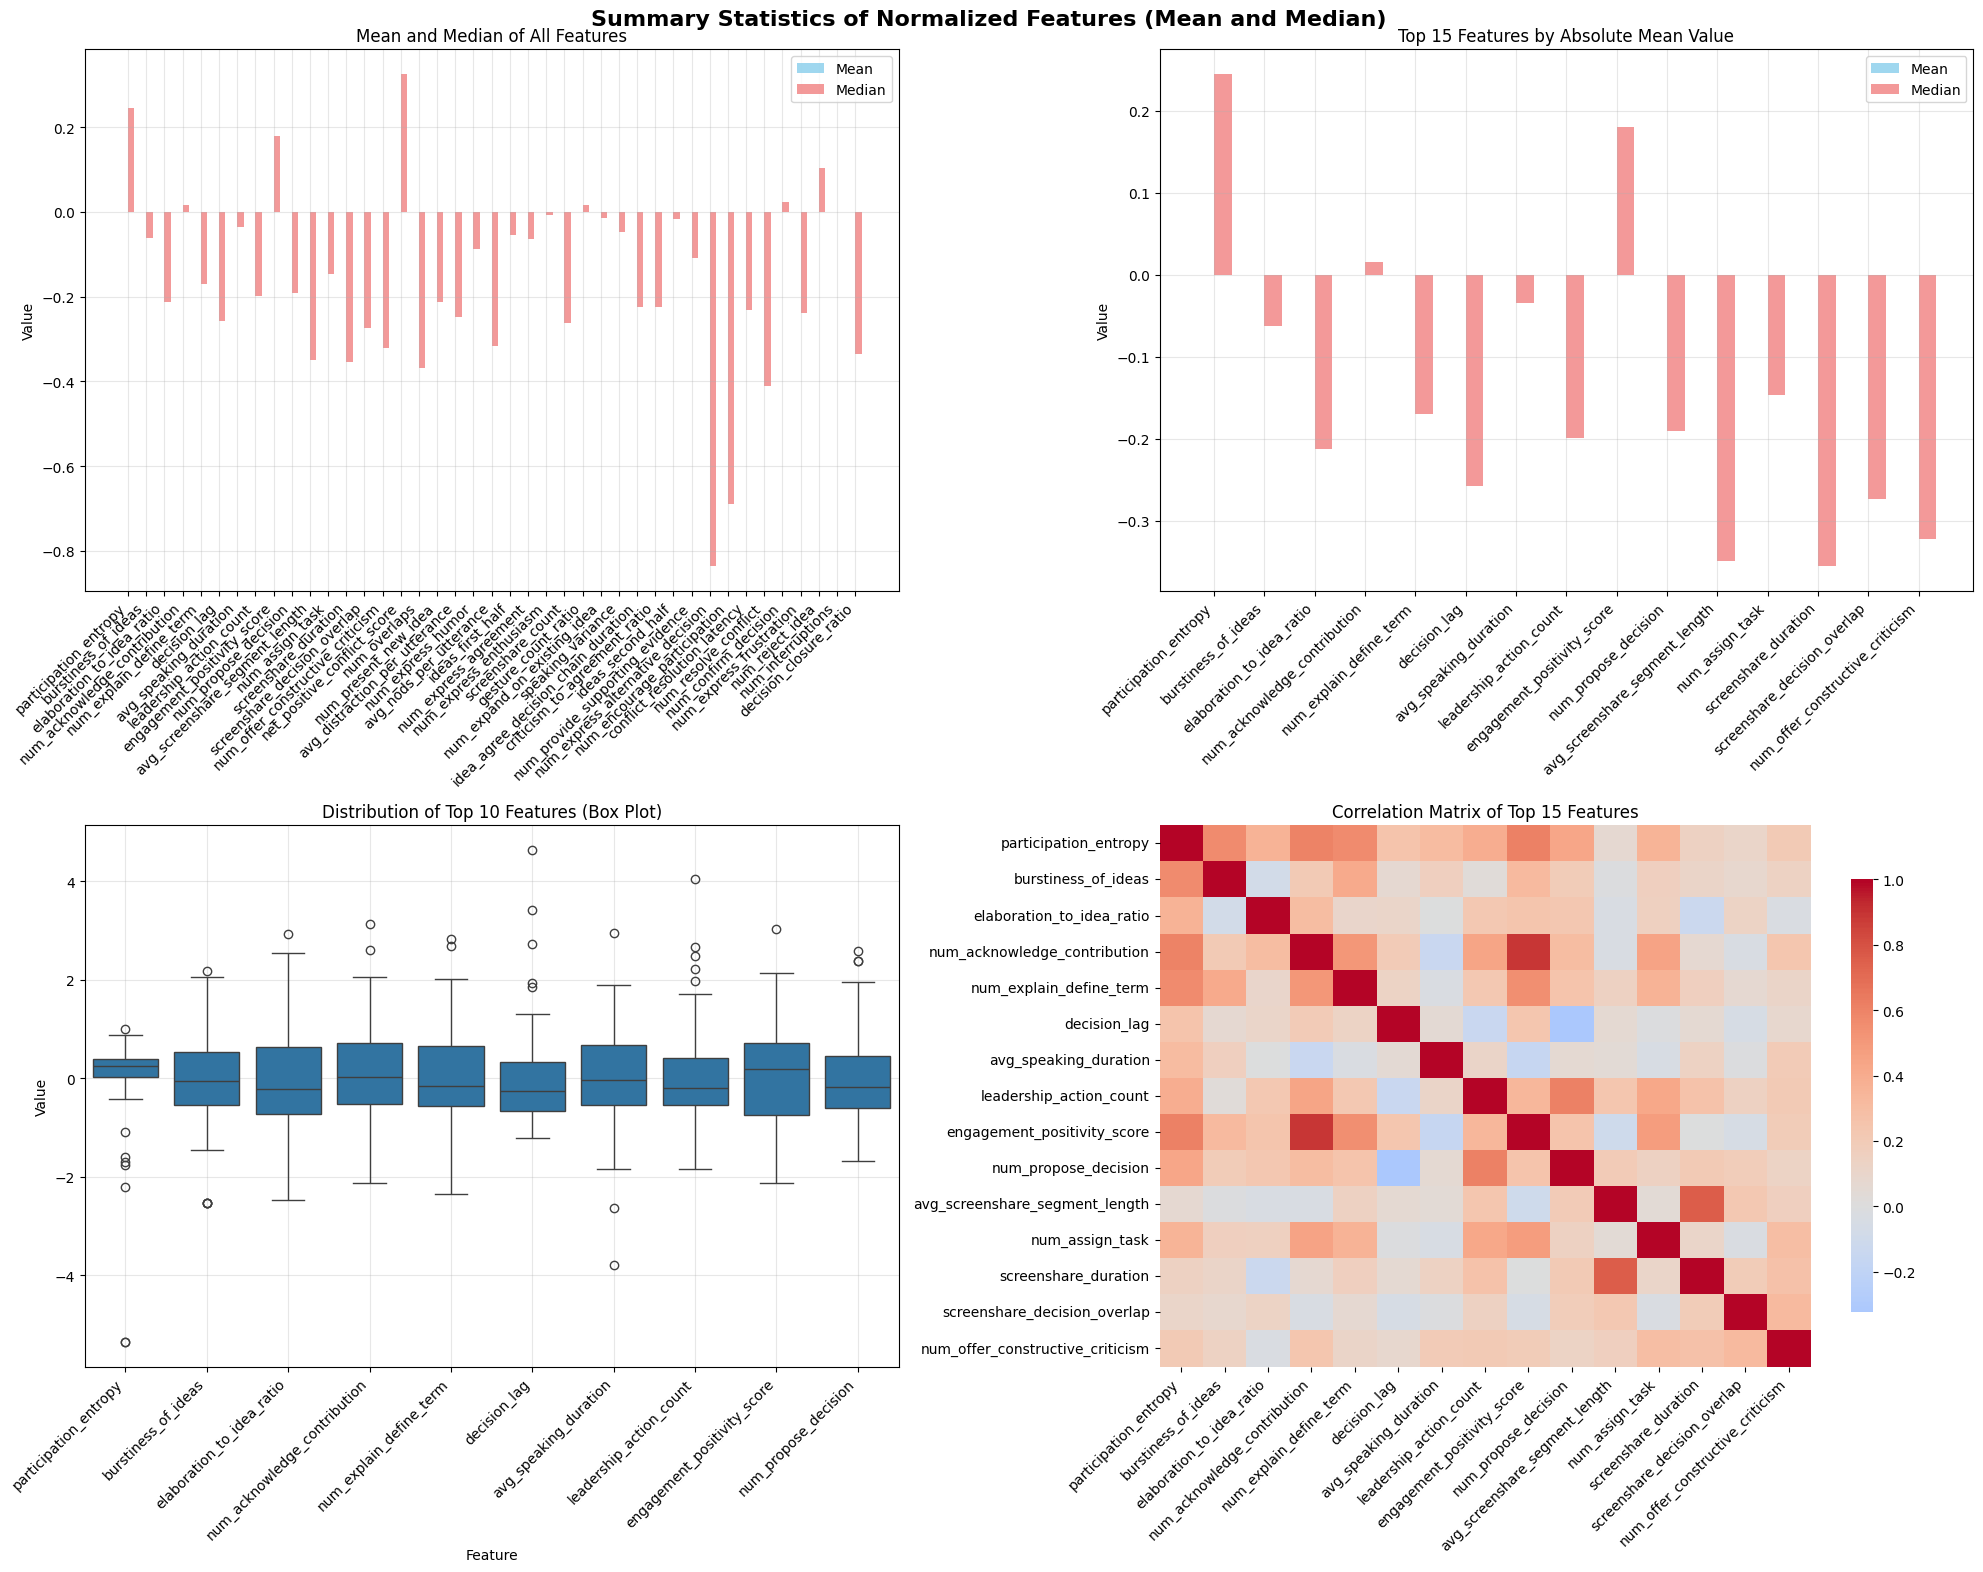

Creating detailed feature analysis...


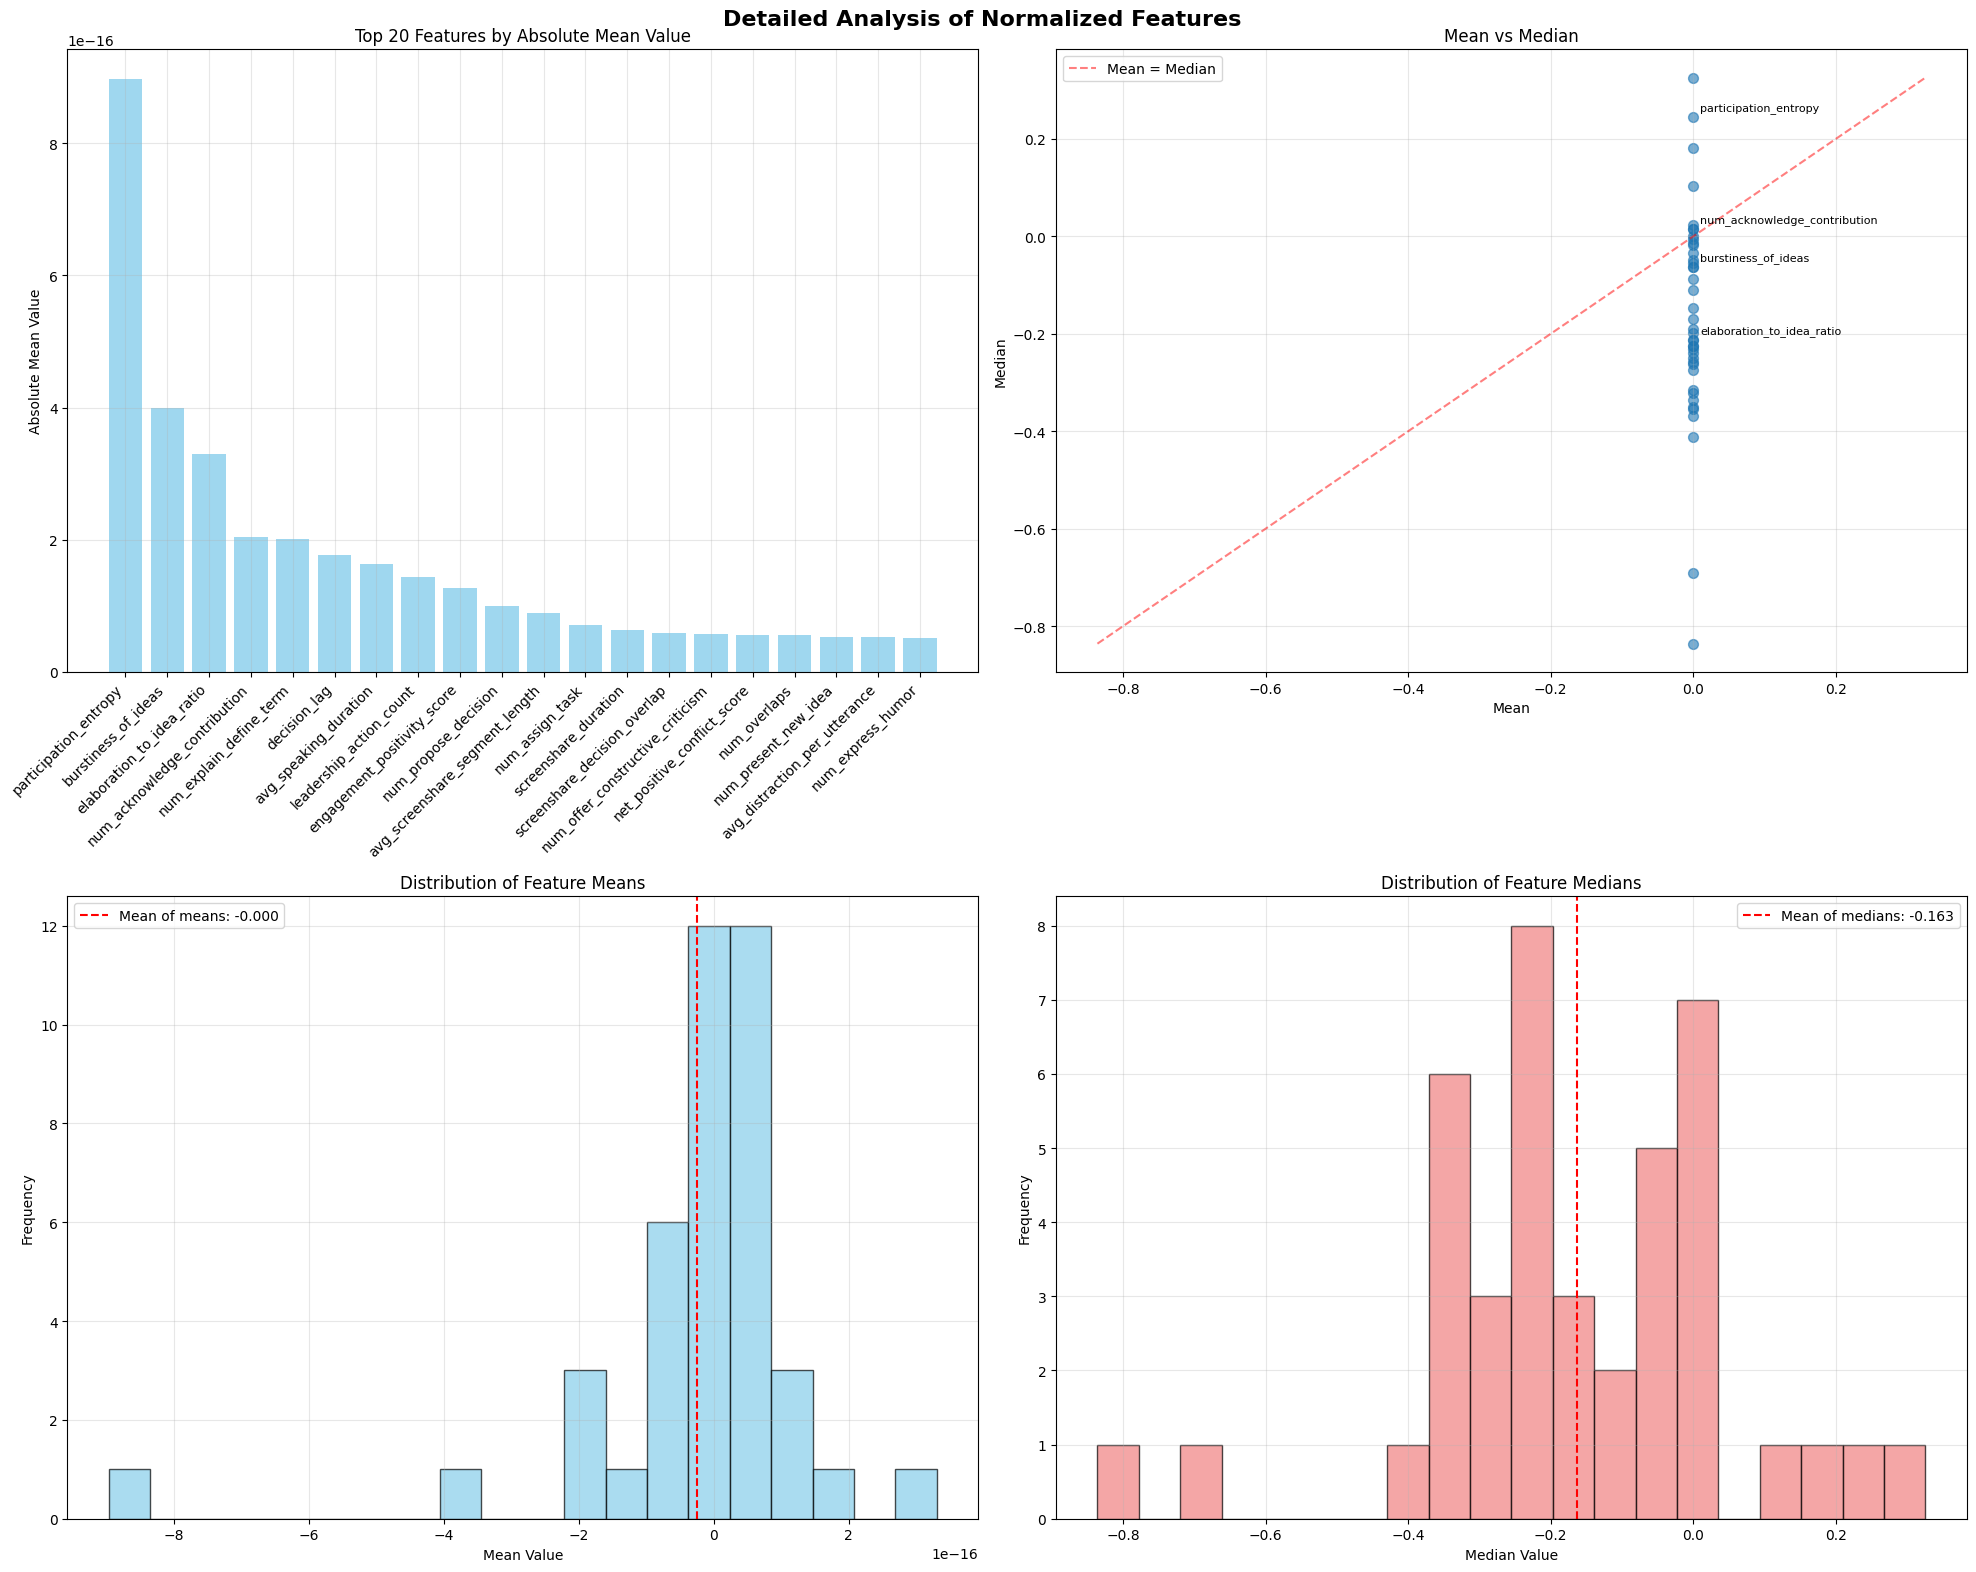

Creating category-based analysis...


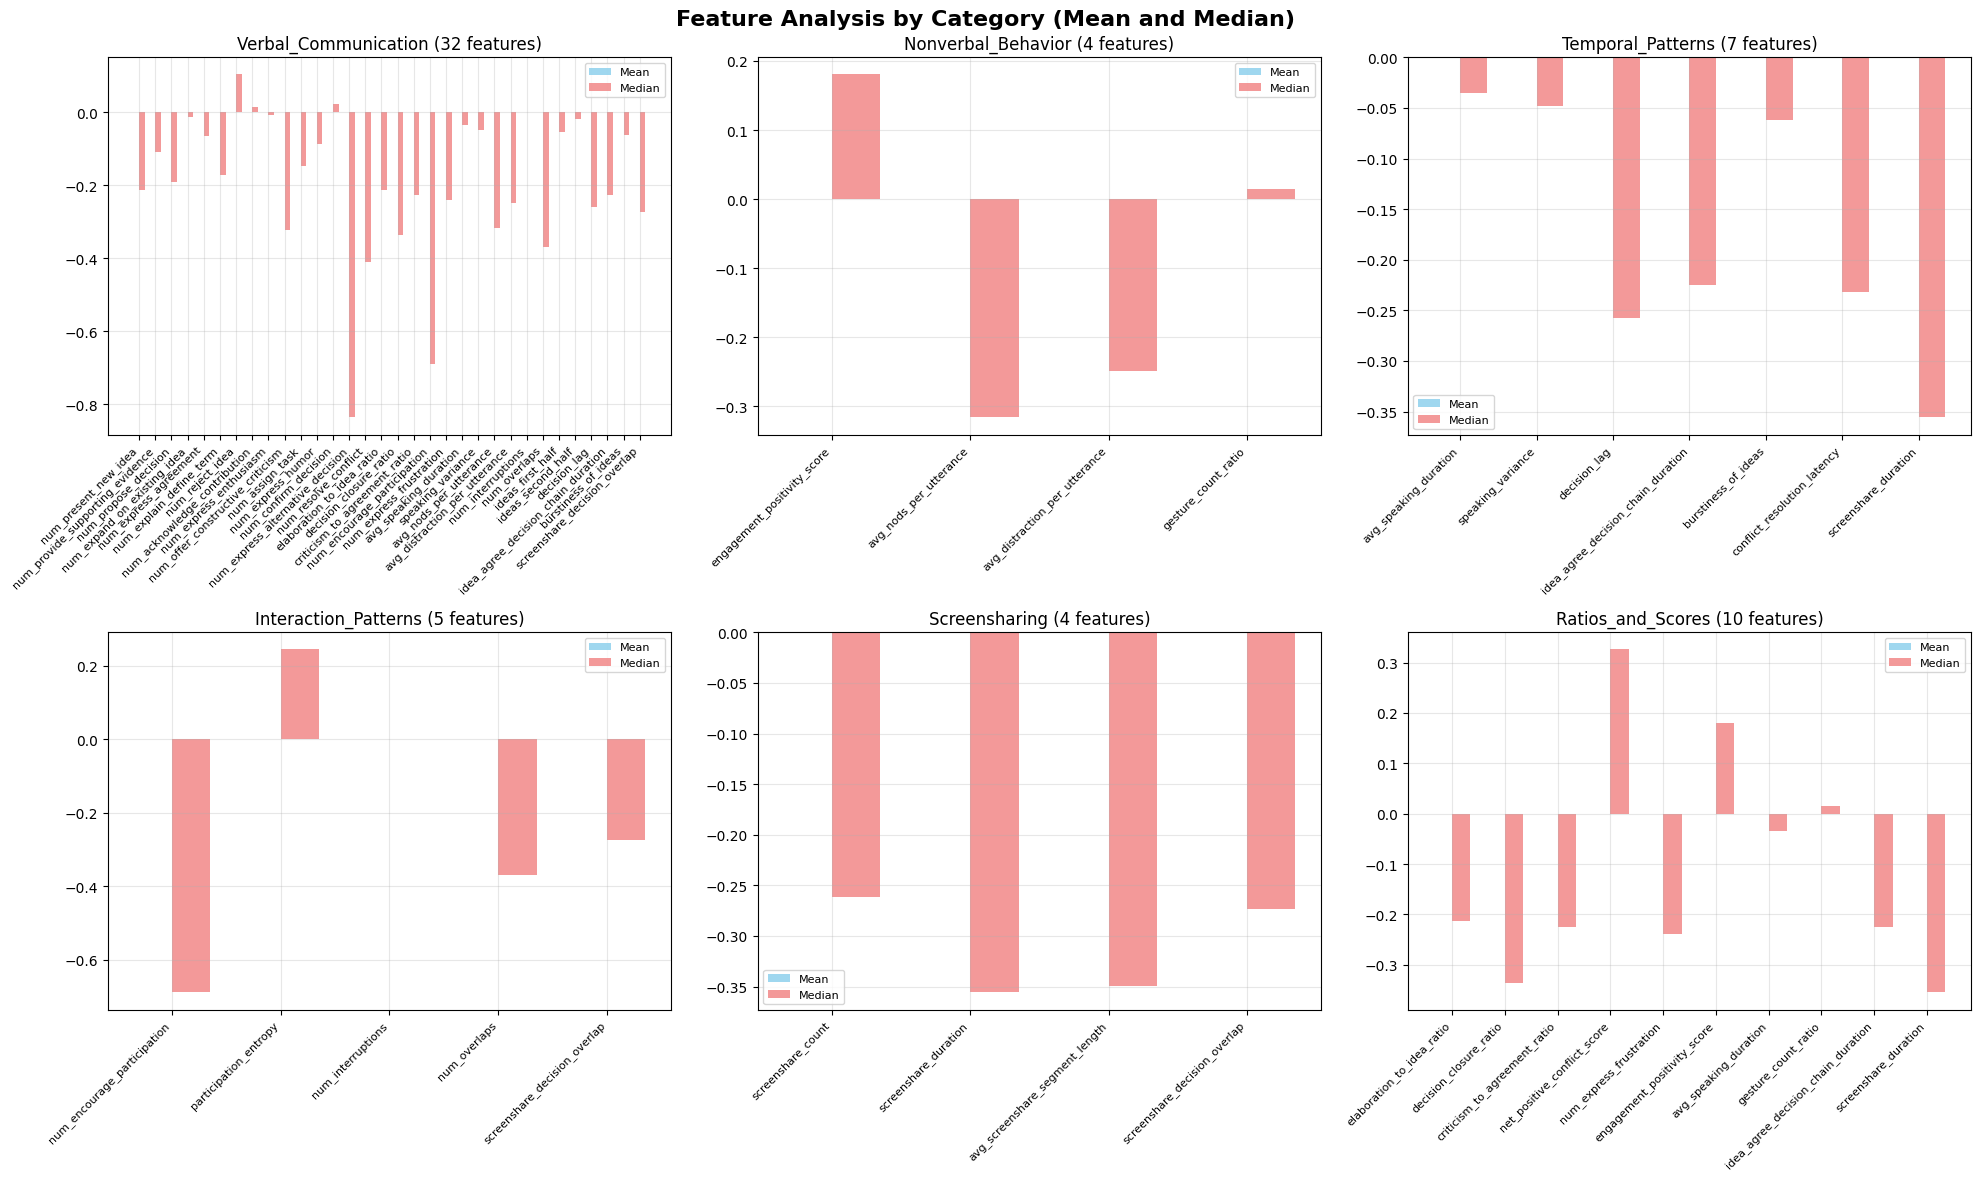

Printing summary statistics...

SUMMARY STATISTICS OF NORMALIZED FEATURES

Total number of features: 41
Features with mean > 0: 22
Features with mean < 0: 17
Features with mean ≈ 0 (|mean| < 0.1): 41

Overall statistics:
Mean of all feature means: -0.0000
Standard deviation of all feature means: 0.0000
Mean of all feature medians: -0.1625
Standard deviation of all feature medians: 0.2183

Top 10 features by absolute mean value:
  participation_entropy: Mean=-0.000, Median=0.245
  burstiness_of_ideas: Mean=-0.000, Median=-0.062
  elaboration_to_idea_ratio: Mean=0.000, Median=-0.213
  num_acknowledge_contribution: Mean=-0.000, Median=0.016
  num_explain_define_term: Mean=-0.000, Median=-0.170
  decision_lag: Mean=0.000, Median=-0.258
  avg_speaking_duration: Mean=-0.000, Median=-0.035
  leadership_action_count: Mean=0.000, Median=-0.199
  engagement_positivity_score: Mean=0.000, Median=0.180
  num_propose_decision: Mean=-0.000, Median=-0.190

Features with largest positive means (most ab

In [26]:

print("Normalizing features...")
df_normalized, feature_names, scaler = normalize_features(all_data_df)

print("Creating summary statistics visualization...")
summary_df = create_summary_statistics_visualization(df_normalized, feature_names)

print("Creating detailed feature analysis...")
detailed_df = create_detailed_feature_analysis(df_normalized, feature_names)

print("Creating category-based analysis...")
categories = create_feature_category_analysis(df_normalized, feature_names)

print("Printing summary statistics...")
print_summary_statistics(summary_df)

# Save summary statistics to CSV
summary_df.to_csv('normalized_features_summary.csv', index=False)
print(f"\nSummary statistics saved to 'normalized_features_summary.csv'")

print(f"\nVisualizations saved as:")
print(f"- normalized_features_summary.png")
print(f"- normalized_features_detailed.png") 
print(f"- normalized_features_by_category.png")

print(f"\nAnalysis complete!")



### logstic regression

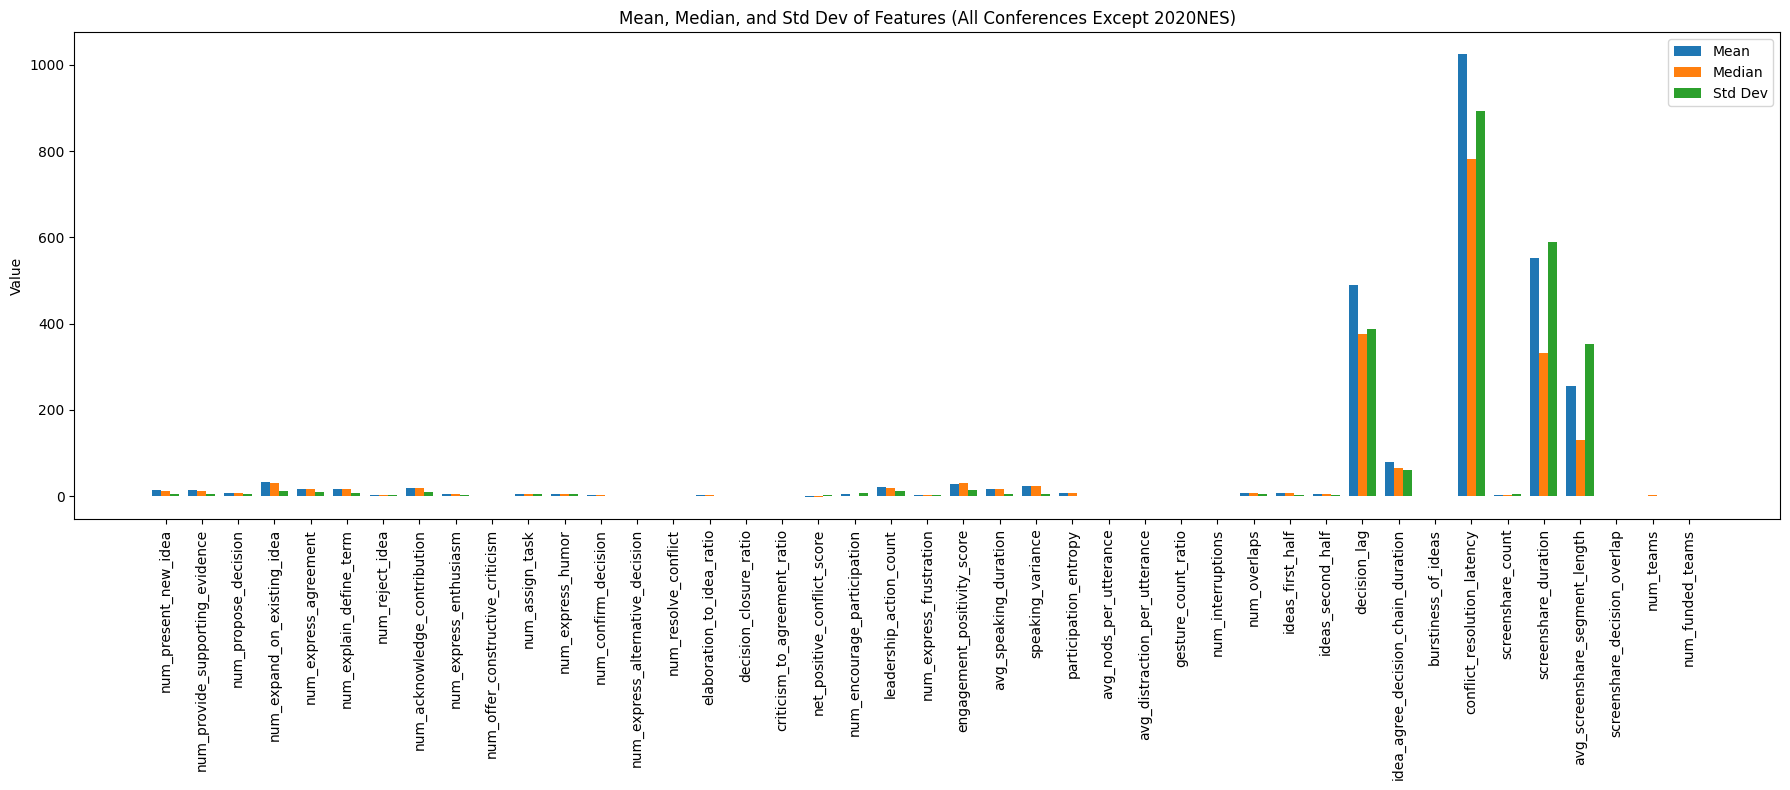

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out rows where conference == '2020NES'
filtered_df = all_data_df[all_data_df['conference'] != '2020NES']

# Exclude non-numeric columns except 'conference'
numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate mean, median, std for each column (across all data)
mean_vals = filtered_df[numeric_cols].mean()
median_vals = filtered_df[numeric_cols].median()
std_vals = filtered_df[numeric_cols].std()

# Plotting
x = np.arange(len(numeric_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, mean_vals, width, label='Mean')
ax.bar(x, median_vals, width, label='Median')
ax.bar(x + width, std_vals, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (All Conferences Except 2020NES)')
ax.legend()
plt.tight_layout()
plt.show()


In [4]:
# Check your data distribution
print("Distribution of num_teams:")
print(all_data_df['num_teams'].value_counts().sort_index())

print("\nDistribution of num_funded_teams:")
print(all_data_df['num_funded_teams'].value_counts().sort_index())

Distribution of num_teams:
num_teams
0    19
1    22
2    27
3     9
4     5
9     1
Name: count, dtype: int64

Distribution of num_funded_teams:
num_funded_teams
0    50
1    22
2     9
3     1
6     1
Name: count, dtype: int64


In [28]:
# Create binary versions
all_data_df['has_teams'] = (all_data_df['num_teams'] > 0).astype(int)
all_data_df['has_funded_teams'] = (all_data_df['num_funded_teams'] > 0).astype(int)

print("Binary target distributions:")
print("has_teams:")
print(all_data_df['has_teams'].value_counts().sort_index())
print("\nhas_funded_teams:")
print(all_data_df['has_funded_teams'].value_counts().sort_index())

Binary target distributions:
has_teams:
has_teams
0    20
1    63
Name: count, dtype: int64

has_funded_teams:
has_funded_teams
0    50
1    33
Name: count, dtype: int64


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def normalize_and_run_logistic_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Normalize features and run logistic regression.
    """
    
    # Separate features and target
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    # Handle missing values
    X = X.fillna(0)
    
    # Split the data WITHOUT stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state  # Removed stratify=y
    )
    
    # Rest of the function remains the same...
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    model = LogisticRegression(random_state=random_state, max_iter=1000)
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    
    print(f"Logistic Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance, X_train_scaled_df, X_test_scaled_df
# Usage example:
# model, scaler, importance, X_train_scaled, X_test_scaled = normalize_and_run_logistic_regression(all_data, 'num_funded_teams')

In [38]:
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

def run_logistic_regression_with_stats_robust(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run logistic regression with robust handling of multicollinearity and perfect separation.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Remove low variance features
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var_selected = variance_selector.fit_transform(X_train)
    X_test_var_selected = variance_selector.transform(X_test)
    
    # Get selected feature names
    selected_features = [feature_columns[i] for i in range(len(feature_columns)) 
                        if variance_selector.get_support()[i]]
    
    print(f"Original features: {len(feature_columns)}")
    print(f"Features after variance threshold: {len(selected_features)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_var_selected)
    X_test_scaled = scaler.transform(X_test_var_selected)
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train_scaled)
    X_test_with_const = sm.add_constant(X_test_scaled)
    
    # Try different fitting methods
    methods_to_try = ['newton', 'bfgs', 'lbfgs', 'powell', 'cg']
    results = None
    
    for method in methods_to_try:
        try:
            print(f"Trying method: {method}")
            model = sm.Logit(y_train, X_train_with_const)
            results = model.fit(method=method, maxiter=1000, disp=0)
            print(f"Success with method: {method}")
            break
        except Exception as e:
            print(f"Method {method} failed: {str(e)[:100]}...")
            continue
    
    if results is None:
        print("All methods failed. Trying with regularization...")
        # Use sklearn with regularization as fallback
        from sklearn.linear_model import LogisticRegression
        sklearn_model = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=random_state)
        sklearn_model.fit(X_train_scaled, y_train)
        
        # Create a mock results object for reporting
        class MockResults:
            def __init__(self, model, feature_names):
                self.params = np.concatenate([[0], model.coef_[0]])  # Add intercept
                self.pvalues = np.ones(len(self.params))  # Placeholder p-values
                self.bse = np.ones(len(self.params)) * 0.1  # Placeholder std errors
                self.tvalues = self.params / self.bse
                self.summary = lambda: print("Using sklearn with L2 regularization (no p-values available)")
        
        results = MockResults(sklearn_model, selected_features)
        y_pred_proba = sklearn_model.predict_proba(X_test_scaled)[:, 1]
        y_pred = sklearn_model.predict(X_test_scaled)
    else:
        # Get predictions for sklearn metrics
        y_pred_proba = results.predict(X_test_with_const)
        y_pred = (y_pred_proba > 0.5).astype(int)
    
    print(f"\nLogistic Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"Accuracy: {(y_pred == y_test).mean():.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    try:
        print(results.summary())
    except:
        print("Summary not available (using sklearn fallback)")
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + selected_features
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    z_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        'z_score': z_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    if len(significant_features) > 0:
        print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    else:
        print("No features significant at p < 0.05")
    
    return results, results_df, scaler, selected_features

In [43]:
def visualize_logistic_features(df, target_column, top_n=15, save_plots=True):
    """
    Create comprehensive visualizations of logistic regression feature importance.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Your dataset
    target_column : str
        Name of the target variable
    top_n : int
        Number of top features to show in plots
    save_plots : bool
        Whether to save plots to files
    """
    
    print(f"Running logistic regression for target: {target_column}")
    print("=" * 60)
    
    # Run logistic regression
    results, coef_df, scaler, selected_features = run_logistic_regression_with_stats_robust(df, target_column)
    
    # Remove intercept for visualization
    feature_df = coef_df[coef_df['feature'] != 'intercept'].copy()
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Coefficient Magnitude Plot (Top N features)
    plt.subplot(2, 3, 1)
    top_features = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.title(f'Top {top_n} Most Predictive Features\n(Red=Negative, Blue=Positive)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add coefficient values on bars
    for i, (bar, coef) in enumerate(zip(bars, top_features['coefficient'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{coef:.3f}', va='center', fontsize=9)
    
    # 2. Coefficient Direction Plot
    plt.subplot(2, 3, 2)
    top_features_signed = feature_df.nlargest(top_n, 'abs_coefficient')
    
    colors = ['red' if x < 0 else 'blue' for x in top_features_signed['coefficient']]
    bars = plt.barh(range(len(top_features_signed)), top_features_signed['coefficient'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features_signed)), top_features_signed['feature'], fontsize=10)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.title(f'Feature Effects on {target_column}\n(Red=Decreases, Blue=Increases)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(axis='x', alpha=0.3)
    
    # 3. Statistical Significance Plot (if available)
    plt.subplot(2, 3, 3)
    if not feature_df['p_value'].isna().all():
        significant_features = feature_df[feature_df['p_value'] < 0.05].nlargest(top_n, 'abs_coefficient')
        if len(significant_features) > 0:
            colors = ['red' if x < 0 else 'blue' for x in significant_features['coefficient']]
            bars = plt.barh(range(len(significant_features)), significant_features['abs_coefficient'], color=colors, alpha=0.7)
            
            plt.yticks(range(len(significant_features)), significant_features['feature'], fontsize=10)
            plt.xlabel('Absolute Coefficient Value', fontsize=12)
            plt.title(f'Statistically Significant Features\n(p < 0.05)', fontsize=14, fontweight='bold')
            plt.grid(axis='x', alpha=0.3)
            
            # Add p-values on bars
            for i, (bar, p_val) in enumerate(zip(bars, significant_features['p_value'])):
                plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'p={p_val:.3f}', va='center', fontsize=9)
        else:
            plt.text(0.5, 0.5, 'No significant features\n(p < 0.05)', ha='center', va='center', 
                    transform=plt.gca().transAxes, fontsize=14)
            plt.title('Statistically Significant Features', fontsize=14, fontweight='bold')
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Statistical Significance', fontsize=14, fontweight='bold')
    
    # 4. Coefficient vs P-value Scatter Plot (if available)
    plt.subplot(2, 3, 4)
    if not feature_df['p_value'].isna().all():
        plt.scatter(feature_df['coefficient'], -np.log10(feature_df['p_value']), alpha=0.6, s=50)
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('-log10(p-value)', fontsize=12)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
        plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p=0.05')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Label top features
        top_features_scatter = feature_df.nlargest(5, 'abs_coefficient')
        for _, row in top_features_scatter.iterrows():
            plt.annotate(row['feature'], (row['coefficient'], -np.log10(row['p_value'])), 
                        xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)
    else:
        plt.text(0.5, 0.5, 'P-values not available\n(Regularized model)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Coefficient vs Statistical Significance', fontsize=14, fontweight='bold')
    
    # 5. Feature Categories Analysis
    plt.subplot(2, 3, 5)
    
    # Define feature categories (you can modify these based on your features)
    categories = {
        'Verbal': ['speak', 'word', 'utterance', 'sentence', 'elaboration', 'idea'],
        'Nonverbal': ['gesture', 'gaze', 'posture', 'movement'],
        'Temporal': ['duration', 'time', 'frequency', 'rate', 'variance'],
        'Interaction': ['turn', 'interrupt', 'overlap', 'participation'],
        'Content': ['task', 'decision', 'evidence', 'criticism', 'enthusiasm'],
        'Technical': ['screenshare', 'technical', 'tool']
    }
    
    category_importance = {}
    for category, keywords in categories.items():
        category_features = feature_df[feature_df['feature'].str.contains('|'.join(keywords), case=False)]
        if len(category_features) > 0:
            category_importance[category] = category_features['abs_coefficient'].mean()
    
    if category_importance:
        categories_list = list(category_importance.keys())
        importance_values = list(category_importance.values())
        colors = plt.cm.Set3(np.linspace(0, 1, len(categories_list)))
        
        bars = plt.bar(categories_list, importance_values, color=colors, alpha=0.7)
        plt.xlabel('Feature Category', fontsize=12)
        plt.ylabel('Average Absolute Coefficient', fontsize=12)
        plt.title('Feature Importance by Category', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        # Add values on bars
        for bar, val in zip(bars, importance_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    else:
        plt.text(0.5, 0.5, 'No category matches found\nfor current features', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Feature Importance by Category', fontsize=14, fontweight='bold')
    
    # 6. Coefficient Distribution
    plt.subplot(2, 3, 6)
    plt.hist(feature_df['coefficient'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Feature Coefficients', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero effect')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'logistic_regression_features_{target_column}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: logistic_regression_features_{target_column}.png")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS:")
    print("=" * 60)
    print(f"Total features analyzed: {len(feature_df)}")
    print(f"Positive coefficients: {len(feature_df[feature_df['coefficient'] > 0])}")
    print(f"Negative coefficients: {len(feature_df[feature_df['coefficient'] < 0])}")
    
    if not feature_df['p_value'].isna().all():
        significant_count = len(feature_df[feature_df['p_value'] < 0.05])
        print(f"Statistically significant (p < 0.05): {significant_count}")
        print(f"Highly significant (p < 0.01): {len(feature_df[feature_df['p_value'] < 0.01])}")
    
    print(f"Mean absolute coefficient: {feature_df['abs_coefficient'].mean():.4f}")
    print(f"Max absolute coefficient: {feature_df['abs_coefficient'].max():.4f}")
    
    return results, coef_df, scaler, selected_features

Running logistic regression for target: has_teams
Original features: 41
Features after variance threshold: 36
Trying method: newton
Method newton failed: Singular matrix...
Trying method: bfgs
Success with method: bfgs

Logistic Regression Results for has_teams
Training samples: 66
Test samples: 17
ROC AUC: 0.667
Accuracy: 0.588

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:              has_teams   No. Observations:                   66
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                           32
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                   1.000
Time:                        14:41:52   Log-Likelihood:            -0.00028998
converged:                       True   LL-Null:                       -35.373
Covariance Type:            nonrobust   LLR p-value:                 9.494e-05
               

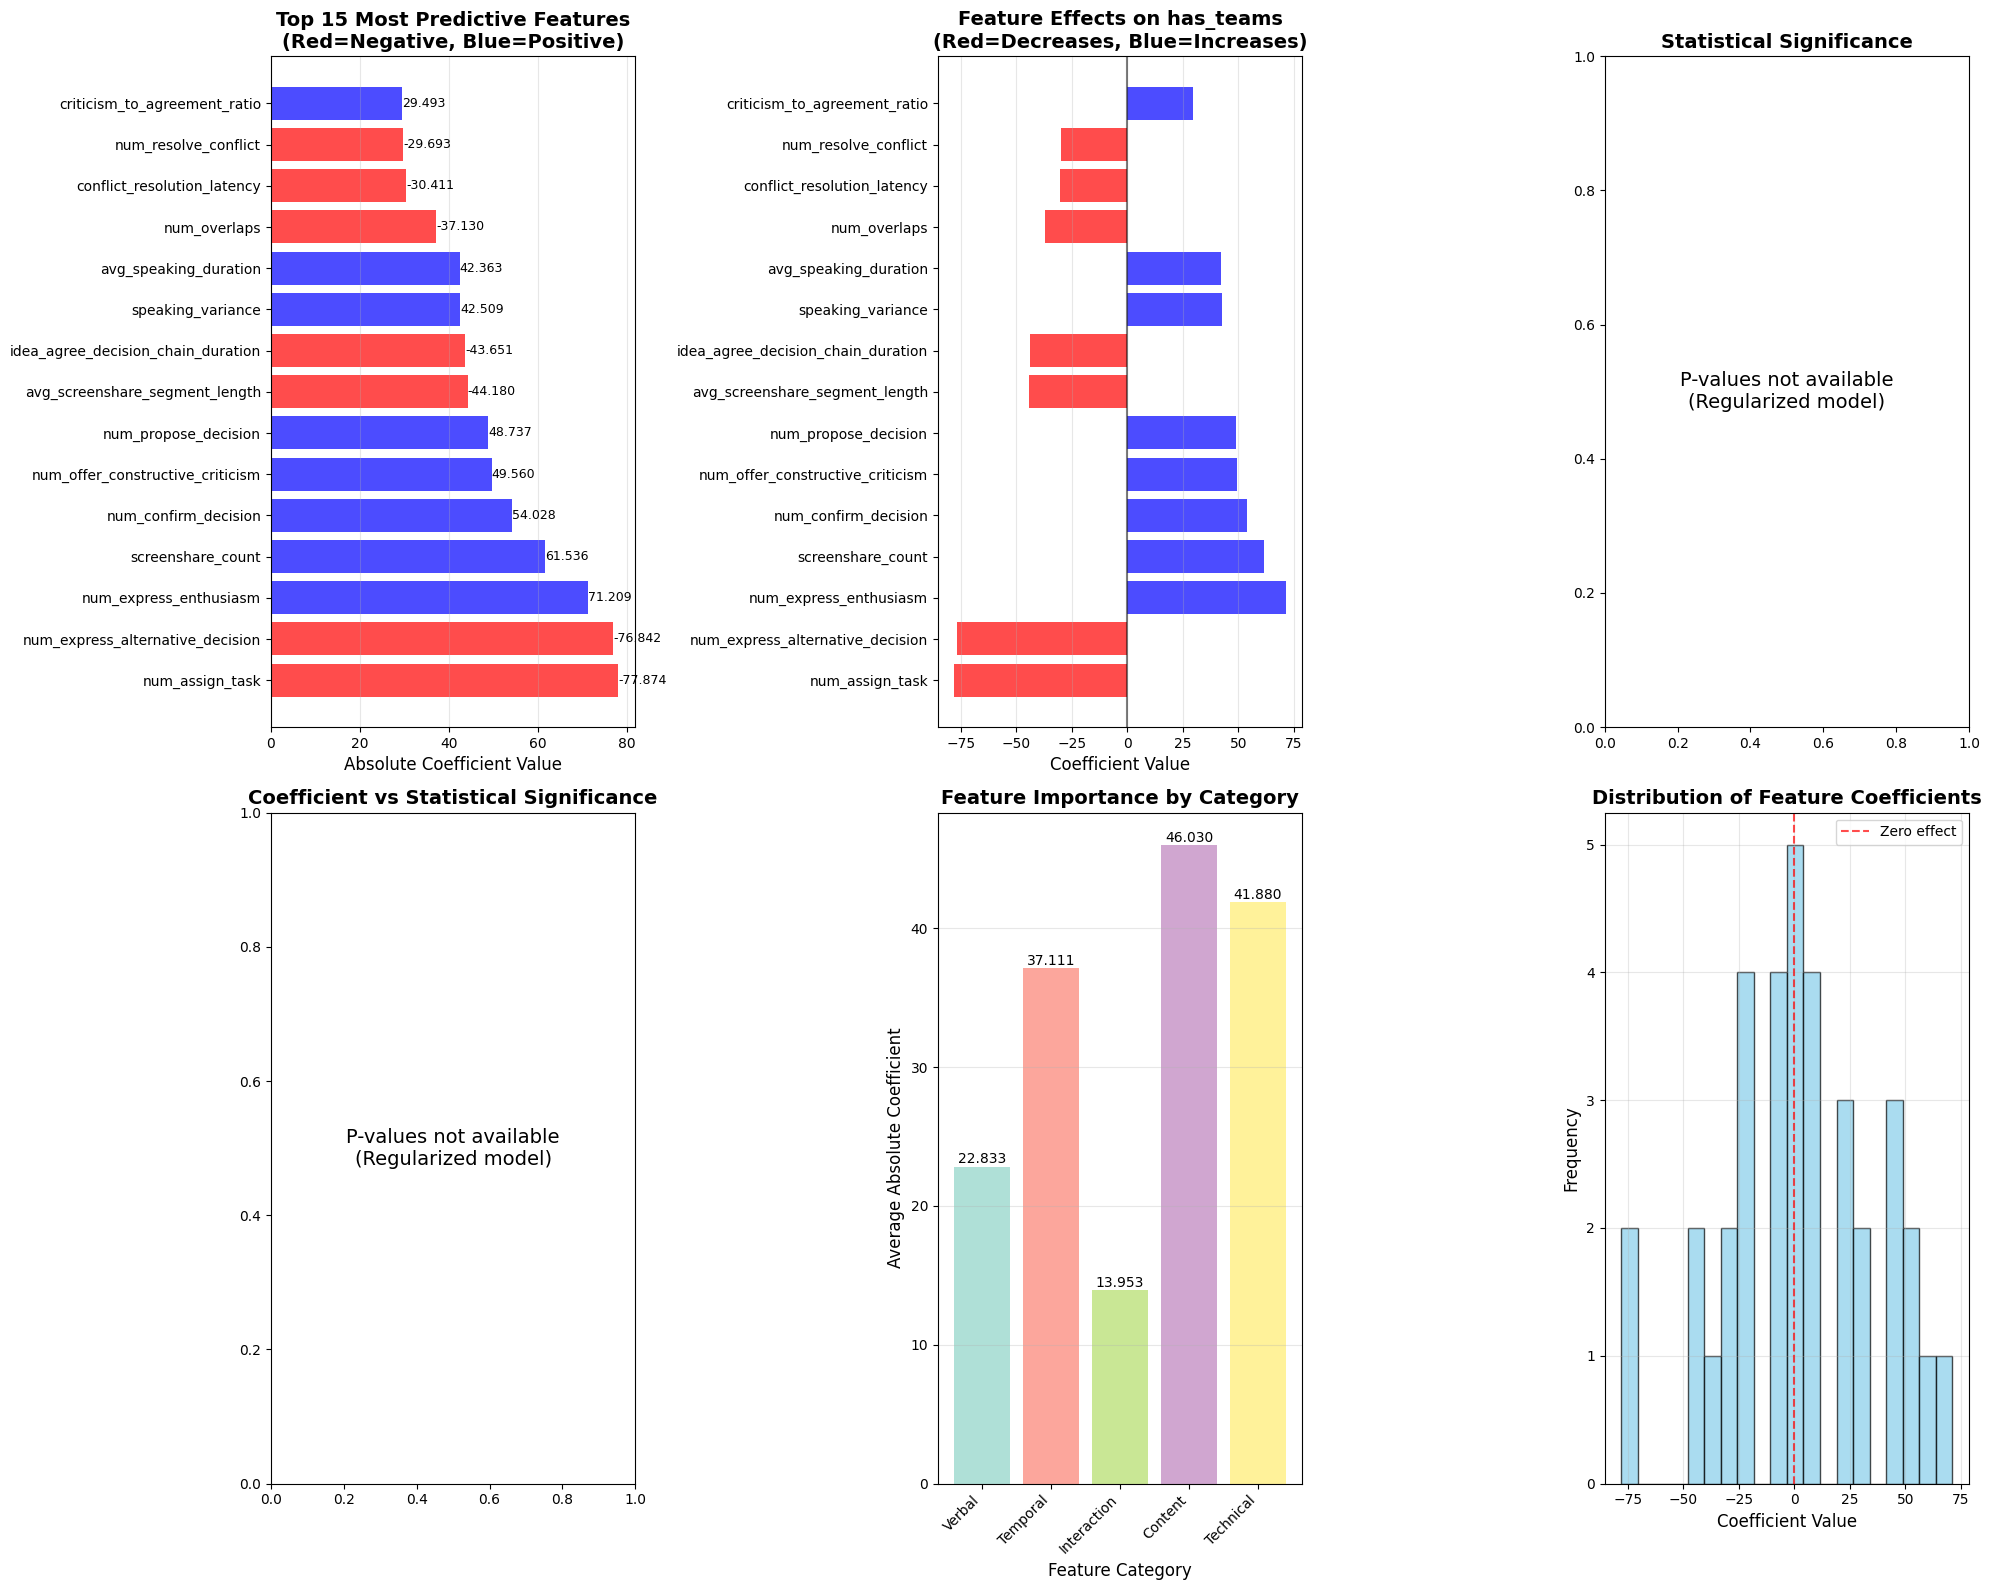


SUMMARY STATISTICS:
Total features analyzed: 36
Positive coefficients: 21
Negative coefficients: 15
Mean absolute coefficient: 27.3291
Max absolute coefficient: 77.8742


In [46]:
df = all_data_df
target = 'has_teams'  # Change this to your target variable
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

Running logistic regression for target: has_funded_teams
Original features: 41
Features after variance threshold: 36
Trying method: newton
Success with method: newton

Logistic Regression Results for has_funded_teams
Training samples: 66
Test samples: 17
ROC AUC: 0.633
Accuracy: 0.529

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:       has_funded_teams   No. Observations:                   66
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                           32
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                  0.5901
Time:                        14:41:57   Log-Likelihood:                -18.441
converged:                       True   LL-Null:                       -44.987
Covariance Type:            nonrobust   LLR p-value:                   0.01098
                 coef    std err          z      P>|z|      

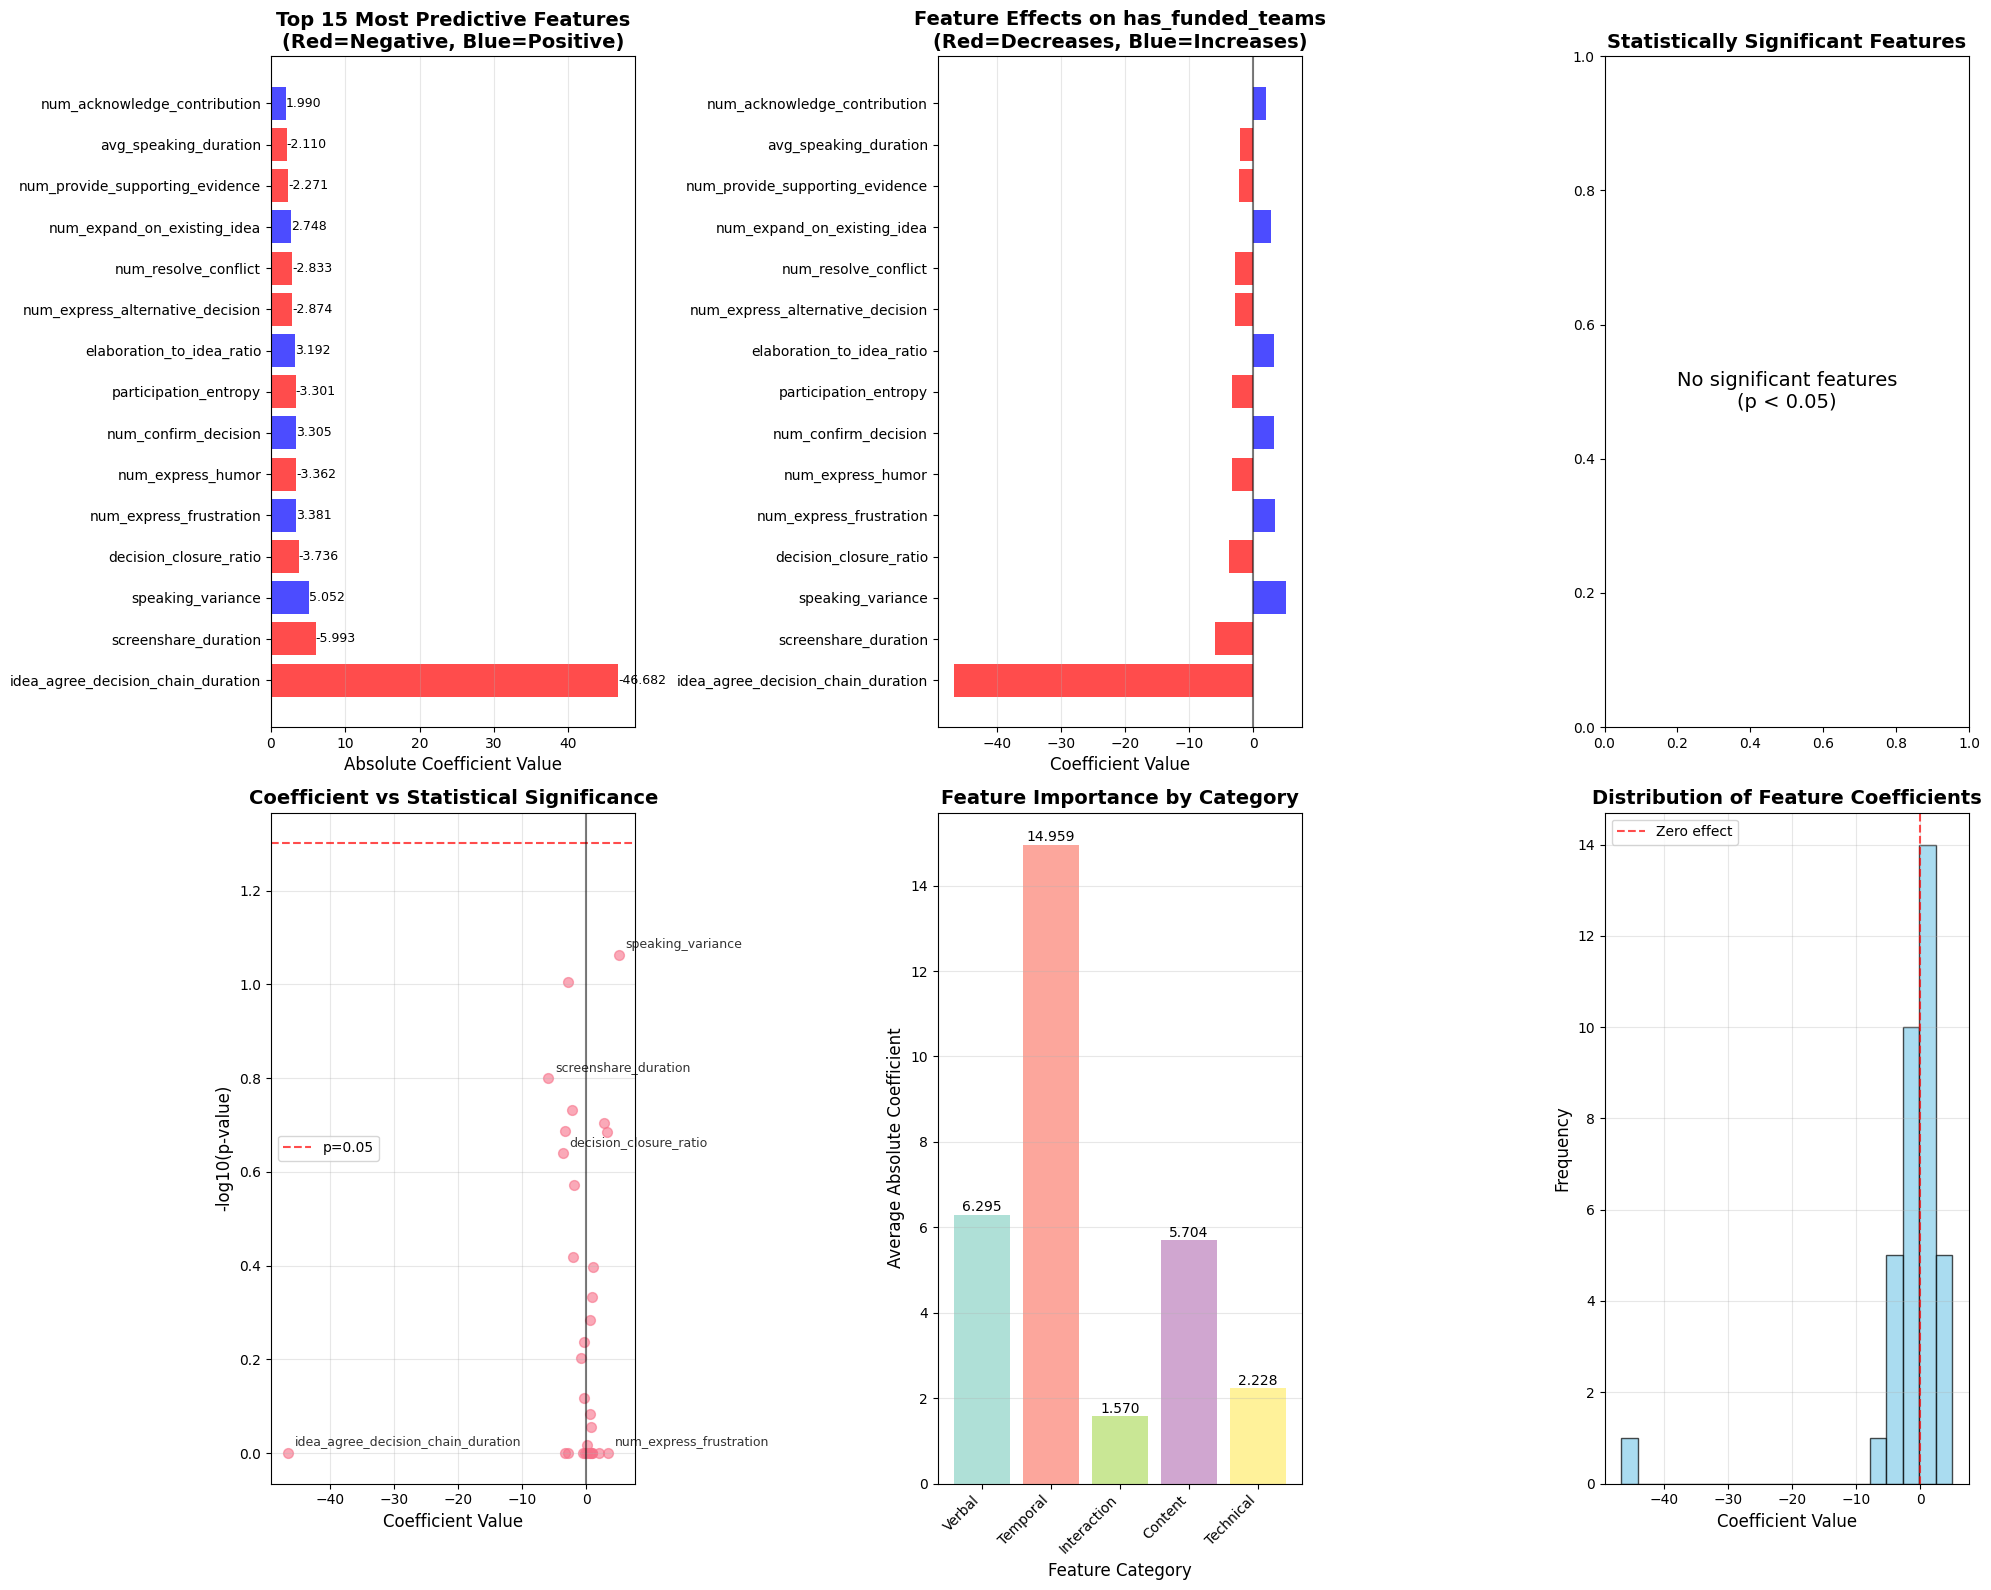


SUMMARY STATISTICS:
Total features analyzed: 36
Positive coefficients: 18
Negative coefficients: 18
Statistically significant (p < 0.05): 0
Highly significant (p < 0.01): 0
Mean absolute coefficient: 2.9484
Max absolute coefficient: 46.6817


In [47]:
df = all_data_df
target = 'has_funded_teams'  # Change this to your target variable
results, coef_df, scaler, features = visualize_logistic_features(df, target)
        

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

import statsmodels.api as sm
from scipy import stats
import numpy as np

import statsmodels.api as sm
from scipy import stats
import numpy as np


def run_linear_regression_with_stats(all_data_df, target_column, test_size=0.2, random_state=42):
    """
    Run linear regression with statistical significance testing using statsmodels.
    """
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Add constant for statsmodels
    X_train_with_const = sm.add_constant(X_train_scaled)
    X_test_with_const = sm.add_constant(X_test_scaled)
    
    # Fit linear regression with statsmodels
    model = sm.OLS(y_train, X_train_with_const)
    results = model.fit()
    
    # Get predictions
    y_pred = results.predict(X_test_with_const)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 60)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Adjusted R²: {results.rsquared_adj:.3f}")
    print(f"F-statistic: {results.fvalue:.3f}")
    print(f"F-statistic p-value: {results.f_pvalue:.3f}")
    
    # Print summary with p-values
    print("\n" + "="*60)
    print("STATSMODELS SUMMARY:")
    print("="*60)
    print(results.summary())
    
    # Extract coefficients and p-values
    feature_names = ['intercept'] + feature_columns
    coefficients = results.params
    p_values = results.pvalues
    std_errors = results.bse
    t_scores = results.tvalues
    
    # Create comprehensive results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'std_error': std_errors,
        't_score': t_scores,
        'p_value': p_values,
        'abs_coefficient': np.abs(coefficients),
        'significant': p_values < 0.05,
        'highly_significant': p_values < 0.01,
        'very_highly_significant': p_values < 0.001
    })
    
    # Add significance stars
    results_df['significance'] = ''
    results_df.loc[results_df['p_value'] < 0.001, 'significance'] = '***'
    results_df.loc[(results_df['p_value'] >= 0.001) & (results_df['p_value'] < 0.01), 'significance'] = '**'
    results_df.loc[(results_df['p_value'] >= 0.01) & (results_df['p_value'] < 0.05), 'significance'] = '*'
    
    print("\n" + "="*60)
    print("FEATURE SIGNIFICANCE SUMMARY:")
    print("="*60)
    print("*** p < 0.001, ** p < 0.01, * p < 0.05")
    print("\nAll Features (sorted by absolute coefficient):")
    print(results_df.sort_values('abs_coefficient', ascending=False).to_string(index=False))
    
    print("\n" + "="*60)
    print("SIGNIFICANT FEATURES (p < 0.05):")
    print("="*60)
    significant_features = results_df[results_df['significant']].sort_values('p_value')
    print(significant_features[['feature', 'coefficient', 'p_value', 'significance']].to_string(index=False))
    
    return results, results_df, scaler

In [32]:
def run_regularized_logistic_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """Run regularized logistic regression to handle multicollinearity."""
    
    from sklearn.linear_model import LogisticRegressionCV
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use cross-validated logistic regression with regularization
    model = LogisticRegressionCV(
        cv=5, 
        penalty='l2', 
        random_state=random_state, 
        max_iter=1000,
        scoring='roc_auc'
    )
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    print(f"Regularized Logistic Regression Results for {target_column}")
    print("=" * 60)
    print(f"Best C (inverse regularization strength): {model.C_[0]:.3f}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"Accuracy: {(y_pred == y_test).mean():.3f}")
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE (Regularized Coefficients):")
    print("="*60)
    print("Note: P-values not available with regularization")
    print("\nTop 10 Most Important Features:")
    print(results_df.head(10).to_string(index=False))
    
    return model, results_df, scaler

# Try the regularized approach
print("Predicting has_teams (regularized):")
model1, results_df1, scaler1 = run_regularized_logistic_regression(all_data_df, 'has_teams')

Predicting has_teams (regularized):
Regularized Logistic Regression Results for has_teams
Best C (inverse regularization strength): 10000.000
Training samples: 66
Test samples: 17
ROC AUC: 0.650
Accuracy: 0.647

FEATURE IMPORTANCE (Regularized Coefficients):
Note: P-values not available with regularization

Top 10 Most Important Features:
                         feature  coefficient  abs_coefficient
                 num_assign_task   -12.548912        12.548912
 num_provide_supporting_evidence    11.425574        11.425574
num_express_alternative_decision   -11.324980        11.324980
               screenshare_count     9.677450         9.677450
           participation_entropy    -9.231363         9.231363
           avg_speaking_duration     9.118357         9.118357
            num_confirm_decision     8.971959         8.971959
          num_express_enthusiasm     7.854482         7.854482
               speaking_variance     7.332707         7.332707
num_offer_constructive_critic

In [42]:
# For binary logistic regression
print("Predicting has_funded_teams with logistic regression:")
results1, results_df1, scaler1, selected_features1 = run_logistic_regression_with_stats_robust(all_data_df, 'has_funded_teams')



Predicting has_funded_teams with logistic regression:
Original features: 41
Features after variance threshold: 36
Trying method: newton
Success with method: newton

Logistic Regression Results for has_funded_teams
Training samples: 66
Test samples: 17
ROC AUC: 0.633
Accuracy: 0.529

STATSMODELS SUMMARY:
                           Logit Regression Results                           
Dep. Variable:       has_funded_teams   No. Observations:                   66
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                           32
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                  0.5901
Time:                        14:35:44   Log-Likelihood:                -18.441
converged:                       True   LL-Null:                       -44.987
Covariance Type:            nonrobust   LLR p-value:                   0.01098
                 coef    std err          z      P>|z|      [0.

### Linear regression

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def run_linear_regression(all_data_df, target_column, test_size=0.2, random_state=42):
    """Run linear regression for continuous targets."""
    
    feature_columns = [col for col in all_data_df.columns 
                      if col not in ['conference', 'session', 'num_teams', 'num_funded_teams', 
                                   'has_teams', 'has_funded_teams']]
    
    X = all_data_df[feature_columns]
    y = all_data_df[target_column]
    
    X = X.fillna(0)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)
    
    model = LinearRegression()
    model.fit(X_train_scaled_df, y_train)
    
    y_pred = model.predict(X_test_scaled_df)
    
    print(f"Linear Regression Results for {target_column}")
    print("=" * 50)
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': model.coef_,
        'abs_coefficient': np.abs(model.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Predictive Features:")
    print(feature_importance.head(10))
    
    return model, scaler, feature_importance

# Run linear regression
print("Predicting num_teams (regression):")
model1, scaler1, importance1 = run_linear_regression_with_stats(all_data_df, 'num_teams')

print("\nPredicting num_funded_teams (regression):")
model2, scaler2, importance2 = run_linear_regression_with_stats(all_data_df, 'num_funded_teams')

Predicting num_teams (regression):
Linear Regression Results for num_teams
Training samples: 66
Test samples: 17
R² Score: -1.080
Adjusted R²: 0.154
F-statistic: 1.328
F-statistic p-value: 0.218

STATSMODELS SUMMARY:
                            OLS Regression Results                            
Dep. Variable:              num_teams   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     1.328
Date:                Tue, 15 Jul 2025   Prob (F-statistic):              0.218
Time:                        14:14:19   Log-Likelihood:                -85.842
No. Observations:                  66   AIC:                             245.7
Df Residuals:                      29   BIC:                             326.7
Df Model:                          36                                         
Covariance Type:            nonrobust                                   